In [1]:
from fastai.vision import *

In [2]:
path = untar_data(URLs.MNIST)
data = (ImageItemList.from_folder(path/'training')
                     .random_split_by_pct()
                     .label_from_folder()
                     .databunch())

In [3]:
class Model(nn.Module):
    def __init__(self, classifier, size=(28,28)):
        super().__init__()
        self.localization = nn.Sequential(
            conv_layer(3, 32, stride=2),
            conv_layer(32, 64, stride=2),
            conv_layer(64, 128, stride=2),
            AdaptiveConcatPool2d(),
            Flatten(), *bn_drop_lin(256, 6)
        )
        self.size = size
        self.sampling_grid = self._build_grid().cuda()
        self.classifier = classifier
    
    def _build_grid(self):
        H,W = self.size
        x = torch.linspace(-1, 1, W)
        y = torch.linspace(-1, 1, H)
        x_t, y_t = [e.contiguous().view(-1) for e in torch.meshgrid(x,y)]
        return torch.stack([x_t, y_t, torch.ones_like(x_t)])[None]
    
    def stn(self, x):
        H,W = self.size
        bs = x.size(0)
        theta = self.localization(x).view(-1,2,3)
        # build grid
        sampling_grid = self.sampling_grid.repeat(bs,1,1)
        grid = theta @ sampling_grid
        grid = grid.view(-1, 2, W, H).permute(0,3,2,1)
        x = F.grid_sample(x, grid)
        return x
        
    def forward(self, x):
        x = self.stn(x)
        return self.classifier(x)

In [4]:
from fastai.callbacks import *

class CustomLoss(nn.Module):
    def __init__(self, base_loss, scale_penalty=0.1):
        super().__init__()
        self.base_loss = base_loss
        self.scale_penalty = scale_penalty
        self.hook = hook_output(m.localization[-1], detach=False)
        self.metric_names = ['cross_entropy', 'scale_loss']
        
    def forward(self, input, target):
        losses = [self.base_loss(input,target)]
        losses += [self.hook.stored[:,[0,4]].mean() * self.scale_penalty]
        self.metrics = dict(zip(self.metric_names, losses))
        return sum(losses)

In [5]:
tmp = create_cnn(data, models.resnet18, metrics=accuracy)
m = Model(tmp.model)
custom_loss = CustomLoss(data.loss_func, scale_penalty=0.5)
learn = Learner(data, m, loss_func=custom_loss, metrics=accuracy, path='tmp', callback_fns=LossMetrics)

In [6]:
l = learn.model.localization[-1]
w = l.weight
b = l.bias
identity = torch.cat([torch.eye(2), torch.zeros(2,1)], dim=1).view(-1)
with torch.no_grad():
    w.fill_(0.)
    b.data = identity.cuda()

In [7]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,cross_entropy,scale_loss
1,1.082756,0.990049,0.842167,0.492935,0.497113
2,0.728931,0.662740,0.937000,0.201514,0.461226
3,0.583927,0.506467,0.966583,0.106999,0.399469
4,0.480620,0.421259,0.977500,0.071083,0.350176
5,0.442509,0.409717,0.978000,0.070302,0.339415


In [8]:
# learn.save('force_scale')
# learn.load('force_scale');

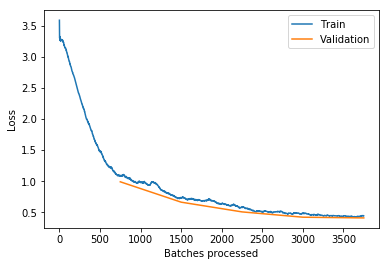

In [9]:
learn.recorder.plot_losses()

In [10]:
x,y = data.one_batch(DatasetType.Valid, denorm=False, cpu=False)

with torch.no_grad():
    W,H = 28,28
    theta = learn.model.localization(x).view(-1,2,3)
    sampling_grid = learn.model.sampling_grid.repeat(64,1,1)
    grid = theta @ sampling_grid
    grid = grid.view(-1, 2, W, H).permute(0,3,2,1)
    x_s = grid[..., 0]
    y_s = grid[..., 1]
    xx = ((x_s + 1.) * W) * 0.5
    yy = ((y_s + 1.) * H) * 0.5
    x_ = F.grid_sample(x, grid)
    y_ = learn.model.classifier(x_).argmax(1)

In [11]:
(theta[:,0,0]).mean(), (theta[:,1,1]).mean()

(tensor(0.6834, device='cuda:0'), tensor(0.6830, device='cuda:0'))

True: 9, Pred: 9


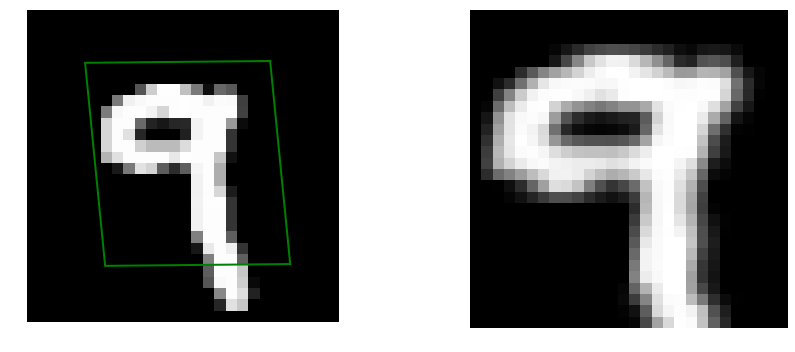

In [56]:
idx = np.random.choice(64)
print(f'True: {y[idx].item()}, Pred: {y_[idx].item()}')
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(13,5))
ax1.imshow(x[idx,0], 'gray')
t = [0,27,-1,-28]
points = torch.stack([xx[idx], yy[idx]], dim=-1).view(-1,2)
x0,x1 = min(0, points[:,0].min()-1), max(W, points[:,0].max()+1)
y1,y0 = min(0, points[:,1].min()-1), max(H, points[:,1].max()+1)
ax1.set_xlim(x0,x1)
ax1.set_ylim(y0,y1)
ax1.add_patch(patches.Polygon(points[t], fill=False, edgecolor='green', lw=2))
ax2.imshow(x_[idx,0], 'gray')
for ax in (ax1,ax2): ax.set_axis_off()
plt.tight_layout()